Importation of modules and functions
===

In [1]:
# Modules
import csv
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import datetime

# Functions
from implementations import *
from helpers import *

# Autoreload
%load_ext autoreload
%autoreload 2

# Set random seed
np.random.seed(1)

Data loading
===

In [2]:
(labels_raw, data_raw, ids_raw) = load_csv_data("data/train.csv")
(t_labels, t_data_raw, t_ids) = load_csv_data("data/test.csv")

# Select portion of data 

In [3]:
"""labels_raw_portion = labels_raw[:10000]
data_raw_portion = data_raw[:10000,:]
ids_raw_portion = ids_raw[:10000]"""

'labels_raw_portion = labels_raw[:10000]\ndata_raw_portion = data_raw[:10000,:]\nids_raw_portion = ids_raw[:10000]'

Data filtering and standardization
===

In [4]:
data_, data_t_, labels, ids = process_data(data_raw, t_data_raw, labels_raw, ids_raw, zero = False)
data, means, variance = standardize(data_)
data_t, means_t, var_t = standardize(data_t_)

The original dimensions of the training data set was 250000 samples and 30 columns. After feature and sample filtering, there are 223877 samples and 23 columns


Build data into matrix form
===

In [5]:
y, tx = build_model_data(data, labels)
y_t, tx_t = build_model_data(data_t,t_labels)

Splitting into train and test set
===

In [6]:
X_train, y_train, X_test, y_test = split_data(tx, y)

print('Standardized and randomized samples are found as the variables X_train, y_train, X_test, y_test. Values' +
      ' are split for testing and training sets with the ratio of 0.8')

Standardized and randomized samples are found as the variables X_train, y_train, X_test, y_test. Values are split for testing and training sets with the ratio of 0.8


Linear regression with gradient descent (GD)
===

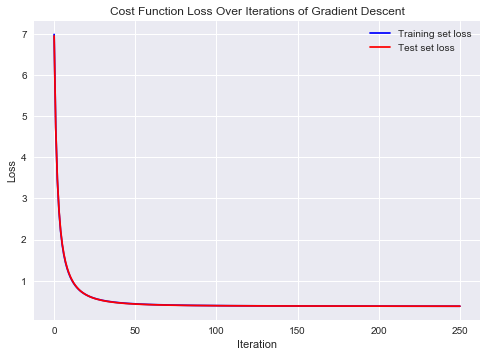

KeyboardInterrupt: 

In [7]:
# initial_w = np.ones(X_train.shape[1])
initial_w = np.random.rand(X_train.shape[1])
losses, ws = least_squares_GD(y_train, X_train, initial_w, max_iters = 250) # fit model and retrieve W's across iterations
test_losses = list(map(lambda x: compute_loss(y_test, X_test, x, method = 'MSE'), ws)) # retrieve losses using test set with ws

plt.style.use('seaborn')
plt.plot(losses, label='Training set loss', c='blue')
plt.plot(test_losses, label='Test set loss', c='red')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Cost Function Loss Over Iterations of Gradient Descent')
plt.legend()
plt.show()

# Make plot with label prediction accuracy

pred_ytrain = list(map(lambda x: predict_labels(x, X_train), ws)) # Training prediction
pred_accuracytrain = list(map(lambda x: pred_accuracy(x, y_train), pred_ytrain))
pred_ytest = list(map(lambda x: predict_labels(x, X_test), ws)) # Test prediction
pred_accuracytest = list(map(lambda x: pred_accuracy(x, y_test), pred_ytest))


plt.plot(pred_accuracytrain, label='Training set prediction accuracy', c='blue')
plt.plot(pred_accuracytest, label='Test set prediction accuracy', c='red')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Prediction Accuracy')
plt.title('Prediction Accuracy Over Iterations of Gradient Descent')
plt.show()


Linear regression with stochastic gradient descent (SGD)
===

In [ ]:
#initial_w = np.ones(X_train.shape[1])
initial_w = np.random.rand(X_train.shape[1])
losses, ws = least_squares_SGD(y_train, X_train, initial_w, max_iters = 250, tol = 1e-4, patience = 5) # fit model, retrieve parameters ws
test_losses = list(map(lambda x: compute_loss(y_test, X_test, x, method = 'MSE'), ws)) # retrieve losses using test set with ws

plt.style.use('seaborn')
plt.plot(losses, label='Training set loss', c='blue')
plt.plot(test_losses, label='Test set loss', c='red')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Cost Function Loss Over Iterations of Stochastic Gradient Descent')
plt.legend()
plt.show()

# Make plot with label prediction accuracy

pred_ytrain = list(map(lambda x: predict_labels(x, X_train), ws)) # Training prediction
pred_accuracytrain = list(map(lambda x: pred_accuracy(x, y_train), pred_ytrain))
pred_ytest = list(map(lambda x: predict_labels(x, X_test), ws)) # Test prediction
pred_accuracytest = list(map(lambda x: pred_accuracy(x, y_test), pred_ytest))


plt.plot(pred_accuracytrain, label='Training set prediction accuracy', c='blue')
plt.plot(pred_accuracytest, label='Test set prediction accuracy', c='red')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Prediction Accuracy')
plt.title('Prediction Accuracy Over Iterations of Stochastic Gradient Descent')
plt.show()


Linear regression using least squares normal equations
===

In [ ]:
w = least_squares(y_train, X_train)

pred_y = predict_labels(w, X_test)
pred_accuracy(pred_y,y_test)

Linear regression using the normal equations with additional polynomial degrees
===

In [ ]:
degrees = range(1,15)
rmse_tr = np.zeros(len(degrees))
rmse_ts = np.zeros(len(degrees))
pred_tr = np.zeros(len(degrees))
pred_ts = np.zeros(len(degrees))


for ind, degree in enumerate(degrees):
    #train the model
    X_test_poly = build_poly(X_test,degree)
    X_train_poly = build_poly(X_train,degree)
    w = least_squares(y_train, X_train_poly)
    rmse_tr[ind] = (np.sqrt(2 * compute_loss(y_train, X_train_poly, w)))
    pred_tr[ind] = pred_accuracy(predict_labels(w,X_train_poly),y_train)
    
    #test the model
    
    rmse_ts[ind] = (np.sqrt(2 * compute_loss(y_test, X_test_poly, w)))
    pred_ts[ind] = (pred_accuracy(predict_labels(w, X_test_poly),y_test))
    
    # print the update
    print("degree: {d} \t rmse_ts: {a} \t  pred_ts: {b}".format(d = degree, a = rmse_ts[ind], b = pred_ts[ind]))


    

# plot the loss
plt.style.use('seaborn')
plt.plot(degrees,rmse_tr, c='blue')
plt.plot(degrees,rmse_ts, c='red')
plt.title('Loss')
plt.xlabel('Polynomial Degree')
plt.ylabel('Loss')
plt.legend(['training set', 'testing set'], loc='upper left')
plt.show()


#plot the accuracy
plt.style.use('seaborn')
plt.plot(degrees,pred_tr, c='blue')
plt.plot(degrees,pred_ts, c='red')
plt.title('Accuracy')
plt.xlabel('Polynomial Degree')
plt.ylabel('Accuracy')
plt.legend(['training set', 'testing set'], loc='upper left')
plt.show()


Linear regression using ridge regression
===

In [ ]:
lambdas = np.logspace(-5, 0, 15)
rmse_tr = []
rmse_ts = []
pred_tr = []
pred_ts = []

for ind, lambda_ in enumerate(lambdas):
    
    w = ridge_regression(y_train, X_train, lambda_)
    rmse_tr.append(np.sqrt(2 * compute_loss(y_train, X_train, w)))
    pred_tr.append(pred_accuracy(predict_labels(w, X_train),y_train))
    
    
    rmse_ts.append(np.sqrt(2 * compute_loss(y_test, X_test, w)))
    pred_ts.append(pred_accuracy(predict_labels(w, X_test),y_test))
    
plt.style.use('seaborn')
plt.semilogx(lambdas,rmse_tr, c='blue')
plt.semilogx(lambdas,rmse_ts, c='red')
plt.legend(['training set', 'testing set'], loc='upper left')
plt.xlabel('Lambda')
plt.ylabel('Loss')
plt.show()

plt.style.use('seaborn')
plt.semilogx(lambdas,pred_tr, c='blue')
plt.semilogx(lambdas,pred_ts, c='red')
plt.xlabel('Lambda')
plt.ylabel('Accuracy')
plt.legend(['training set', 'testing set'], loc='upper right')
plt.show()

# print(np.max(pred))

# Logistic regression

iteration: 0 | loss : 299862.3759292623
iteration: 500 | loss : 109068.96144194312
iteration: 1000 | loss : 108249.84296679971
iteration: 1500 | loss : 107966.96781448204
iteration: 2000 | loss : 107826.80589751503
iteration: 2500 | loss : 107749.40414719938
iteration: 3000 | loss : 107703.64421709807
iteration: 3500 | loss : 107675.3111113282
iteration: 4000 | loss : 107657.18568509872
iteration: 4500 | loss : 107645.30595363729
iteration: 5000 | loss : 107637.36965655012
iteration: 5500 | loss : 107631.98207888489


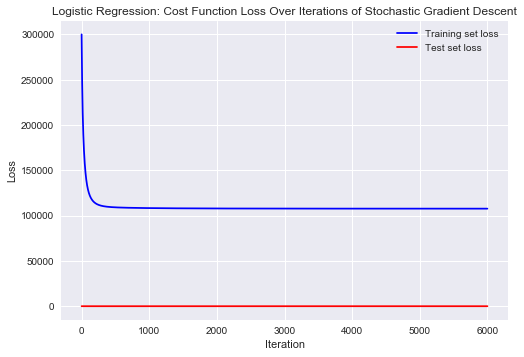

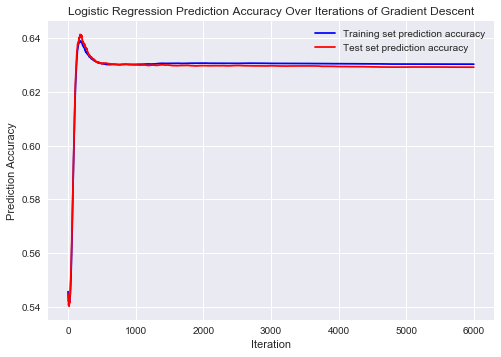

In [72]:
initial_w = np.random.rand(X_train.shape[1])
losses, ws = logistic_regression(y_train, X_train, initial_w, method = 'gd', max_iters = 6000) # fit model, retrieve parameters ws
test_losses = list(map(lambda x: compute_loss(y_test, X_test, x, method = 'MSE'), ws)) # retrieve losses using test set with ws

plt.style.use('seaborn')
plt.plot(losses, label='Training set loss', c='blue')
plt.plot(test_losses, label='Test set loss', c='red')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Logistic Regression: Cost Function Loss Over Iterations of Stochastic Gradient Descent')
plt.legend()
plt.show()

# Make plot with label prediction accuracy

pred_ytrain = list(map(lambda x: predict_labels(x, X_train), ws)) # Training prediction
pred_accuracytrain = list(map(lambda x: pred_accuracy(x, y_train), pred_ytrain))
pred_ytest = list(map(lambda x: predict_labels(x, X_test), ws)) # Test prediction
pred_accuracytest = list(map(lambda x: pred_accuracy(x, y_test), pred_ytest))


plt.plot(pred_accuracytrain, label='Training set prediction accuracy', c='blue')
plt.plot(pred_accuracytest, label='Test set prediction accuracy', c='red')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Prediction Accuracy')
plt.title('Logistic Regression Prediction Accuracy Over Iterations of Gradient Descent')
plt.show()

Logistic regression using Newton's method
===

In [16]:
# initial_w = np.random.rand(X_train.shape[1])
# losses, ws = logistic_hessian(y_train, X_train, initial_w) # fit model, retrieve parameters ws
# test_losses = list(map(lambda x: compute_loss(y_test, X_test, x, method = 'MSE'), ws)) # retrieve losses using test set with ws

# plt.style.use('seaborn')
# plt.plot(losses, label='Training set loss', c='blue')
# plt.plot(test_losses, label='Test set loss', c='red')
# plt.xlabel('Iteration')
# plt.ylabel('Loss')
# plt.title('Logistic Regression: Cost Function Loss Over Iterations of Stochastic Gradient Descent')
# plt.legend()
# plt.show()

# # Make plot with label prediction accuracy

# pred_ytrain = list(map(lambda x: predict_labels(x, X_train), ws)) # Training prediction
# pred_accuracytrain = list(map(lambda x: pred_accuracy(x, y_train), pred_ytrain))
# pred_ytest = list(map(lambda x: predict_labels(x, X_test), ws)) # Test prediction
# pred_accuracytest = list(map(lambda x: pred_accuracy(x, y_test), pred_ytest))


# plt.plot(pred_accuracytrain, label='Training set prediction accuracy', c='blue')
# plt.plot(pred_accuracytest, label='Test set prediction accuracy', c='red')
# plt.legend()
# plt.xlabel('Iteration')
# plt.ylabel('Prediction Accuracy')
# plt.title('Logistic Regression Prediction Accuracy Over Iterations of Gradient Descent')
# plt.show()

"""IF YOU READ THIS: I tried doing something here so that LR is faster and more accurate,
the problem is that we can't calculate things that way, it's too big, but maybe I'll find a way
another time."""

Gradient Descent(1/99): loss=150.62869809900818, w0=-5.384635615656, w1=0.9277140142940936
Gradient Descent(2/99): loss=412627990243.2766, w0=242898.8838108576, w1=-41036.745978080166
Gradient Descent(3/99): loss=2.1353537156003356e+53, w0=-8.554694866367615e+25, w1=-5.0591261993963144e+23


LinAlgError: Singular matrix

# Regularized Logistic Regression

In [ ]:
lambdas = np.logspace(-5, 0, 5)
loss_tr = []
loss_ts = []
pred_tr = []
pred_ts = []
initial_w = np.random.rand(X_train.shape[1])

# There is a runtime warning but just be patient

for ind, lambda_ in enumerate(lambdas):
    
    losses, ws = reg_logistic_regression(y_train, X_train, initial_w, lamb = lambda_, methods ='gd', gamma = 0.01, max_iters=6000)
    loss_tr.append(losses[-1])
    best_w = ws[-1]
    
    pred_tr.append(pred_accuracy(predict_labels(best_w, X_train),y_train))
    
    test_losses = compute_loss(y_test, X_test, best_w, lam = lambda_, method = 'reg_logistic') # retrieve losses using test set with ws
    loss_ts.append(test_losses)
    pred_ts.append(pred_accuracy(predict_labels(best_w, X_test),y_test))

    
plt.style.use('seaborn')
plt.semilogx(lambdas,loss_tr, c='blue')
plt.semilogx(lambdas,loss_ts, c='red')
plt.legend(['training set', 'testing set'], loc='upper left')
plt.xlabel('Lambda')
plt.ylabel('Loss')
plt.show()

plt.style.use('seaborn')
plt.semilogx(lambdas,pred_tr, c='blue')
plt.semilogx(lambdas,pred_ts, c='red')
plt.xlabel('Lambda')
plt.ylabel('Accuracy')
plt.legend(['training set', 'testing set'], loc='upper right')
plt.show()

####


In [ ]:
# lamb = 0.1
# losses, ws = reg_logistic_regression(y_train, X_train, 
#                          initial_w, lamb, methods = 'gd', 
#                          gamma = 0.01, max_iters= 6000)

# test_losses = list(map(lambda x: compute_loss(y_test, X_test, x, lam = lamb, method = 'reg_logistic'), ws)) # retrieve losses using test set with ws
# plt.style.use('seaborn')
# plt.plot(losses, label='Training set loss', c='blue')
# plt.plot(test_losses, label='Test set loss', c='red')
# plt.xlabel('Iteration')
# plt.ylabel('Loss')
# plt.title('Regularized Logistic Regression: Cost Function Loss Over Iterations of Gradient Descent')
# plt.legend()
# plt.show()

# # Make plot with label prediction accuracy

# pred_ytrain = list(map(lambda x: predict_labels(x, X_train), ws)) # Training prediction
# pred_accuracytrain = list(map(lambda x: pred_accuracy(x, y_train), pred_ytrain))
# pred_ytest = list(map(lambda x: predict_labels(x, X_test), ws)) # Test prediction
# pred_accuracytest = list(map(lambda x: pred_accuracy(x, y_test), pred_ytest))


# plt.plot(pred_accuracytrain, label='Training set prediction accuracy', c='blue')
# plt.plot(pred_accuracytest, label='Test set prediction accuracy', c='red')
# plt.legend()
# plt.xlabel('Iteration')
# plt.ylabel('Prediction Accuracy')
# plt.title('Regularized Logistic Regression Prediction Accuracy Over Iterations of Gradient Descent')
# plt.show()

### Using the polynomial model

In [ ]:
degree = 12
X_test_poly = build_poly(data_test,degree)
X_train_poly = build_poly(data,degree)
w = least_squares(labels, X_train_poly)
rmse_tr = (np.sqrt(2 * compute_loss(labels, X_train_poly, w)))
pred_tr = pred_accuracy(predict_labels(w,X_train_poly),labels)

test_prediction = predict_labels(w, X_test_poly)
    

In [ ]:
name = "prediction.csv"
ids = ids_test
y_pred = test_prediction
create_csv_submission(ids, y_pred, name)

# this yielded like 0.62 on kaggle

### Using logistic regression

In [7]:
initial_w = np.ones(tx.shape[1])
y[y == -1] = 0
losses, ws = logistic_regression(y, tx, initial_w, method = 'gd', max_iters = 6000) # fit model, retrieve parameters ws

iteration: 0 | loss : 284217.2203528563
iteration: 500 | loss : 137155.53474449873
iteration: 1000 | loss : 137190.58725620058
iteration: 1500 | loss : 137208.54055715867
iteration: 2000 | loss : 137203.54109907337
iteration: 2500 | loss : 137189.91806044974
iteration: 3000 | loss : 137176.61446005013
iteration: 3500 | loss : 137166.42092102865
iteration: 4000 | loss : 137159.43355035852
iteration: 4500 | loss : 137154.95353826255
iteration: 5000 | loss : 137152.22296142636
iteration: 5500 | loss : 137150.63869066958


In [8]:
pred = tx_t.dot(ws[-1])
pred[np.where(pred <= 0.5)] = -1
pred[np.where(pred > 0.5)] = 1

name = "prediction.csv"
create_csv_submission(t_ids, pred, name)

# this yields 0.73 on kaggle